  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-6zxof_2h
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-6zxof_2h
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
Choose search type:
1. Image-to-Image
2. Text-to-Image
Enter 1 or 2: 1

 Upload an image to find visually similar CIFAR-10 images.


Saving Test_1.jpg to Test_1.jpg


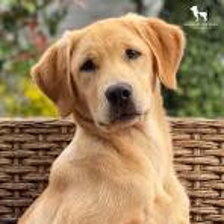


 Top-5 similar CIFAR-10 images:


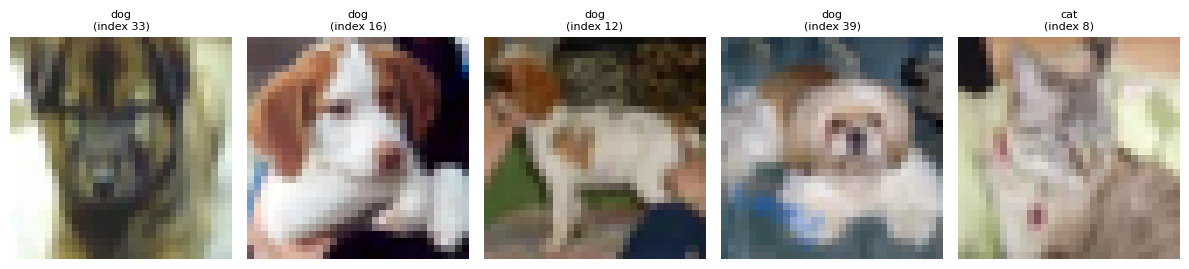

In [2]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

import torch
import clip
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
import io
from google.colab import files
device = "cuda" if torch.cuda.is_available() else "cpu"
# Load CLIP model and preprocessing function
model, preprocess = clip.load("ViT-B/32", device=device)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                         (0.26862954, 0.26130258, 0.27577711))
])

dataset = CIFAR10(root="./data", train=False, download=True)
images = [transform(dataset[i][0]) for i in range(200)]
image_labels = [dataset[i][1] for i in range(200)]
original_images = [dataset[i][0] for i in range(200)]
image_batch = torch.stack(images).to(device)

# Generate CLIP image embeddings
with torch.no_grad():
    image_embeddings = model.encode_image(image_batch).float()
    image_embeddings /= image_embeddings.norm(dim=-1, keepdim=True)

# Generate CLIP text embeddings (class names)
text_tokens = clip.tokenize(class_names).to(device)
with torch.no_grad():
    text_embeddings = model.encode_text(text_tokens).float()
    text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)

import clip
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess_transform = clip.load("ViT-B/32", device=device)

choice = input("Choose search type:\n1. Image-to-Image\n2. Text-to-Image\nEnter 1 or 2: ").strip()

if choice == '1':

    print("\n Upload an image to find visually similar CIFAR-10 images.")
    uploaded = files.upload()

    for filename in uploaded.keys():
        uploaded_image = Image.open(io.BytesIO(uploaded[filename])).convert("RGB")
        uploaded_image = uploaded_image.resize((224, 224))
        display(uploaded_image)


        image_tensor = preprocess_transform(uploaded_image).unsqueeze(0).to(device)


        with torch.no_grad():
            uploaded_embedding = model.encode_image(image_tensor).float()
            uploaded_embedding /= uploaded_embedding.norm(dim=-1, keepdim=True)


        similarities = (uploaded_embedding @ image_embeddings.T).squeeze(0)
        topk = 5
        top_indices = similarities.topk(topk).indices.cpu().numpy()

        print(f"\n Top-{topk} similar CIFAR-10 images:")
        plt.figure(figsize=(12, 3))
        for i, idx in enumerate(top_indices):
            plt.subplot(1, topk, i+1)
            plt.imshow(original_images[idx])
            plt.title(f"{class_names[image_labels[idx]]}\n(index {idx})", fontsize=8)
            plt.axis('off')
        plt.tight_layout()
        plt.show()

elif choice == '2':
    #  TEXT-TO-IMAGE SEARCH
    query = input("\n Enter your text query (e.g., 'a dog', 'an airplane'): ")

    # Tokenize and encode the query
    text_token = clip.tokenize([query]).to(device)
    with torch.no_grad():
        text_embedding = model.encode_text(text_token).float()
        text_embedding /= text_embedding.norm(dim=-1, keepdim=True)

    # Find most relevant CIFAR-10 images
    similarities = (text_embedding @ image_embeddings.T).squeeze(0)
    topk = 5
    top_indices = similarities.topk(topk).indices.cpu().numpy()

    print(f"\n Top-{topk} images matching: \"{query}\"")
    plt.figure(figsize=(12, 3))
    for i, idx in enumerate(top_indices):
        plt.subplot(1, topk, i+1)
        plt.imshow(original_images[idx])
        plt.title(f"{class_names[image_labels[idx]]}\n(index {idx})", fontsize=8)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

else:
    print("❌ Invalid option. Please enter 1 or 2.")